In [2]:
import matplotlib
matplotlib.use('Agg')

import collections
import numpy as np
import os
import h5py
from scipy.stats import zscore
import pyret.filtertools as ft
import pyret.spiketools as sp
import pyret.stimulustools as st
from deepretina.toolbox import load_model, load_partial_model, rolling_window
from deepretina.io import despine
from deepretina.metrics import cc
from scipy.interpolate import interp1d
from scipy.signal import detrend

from tqdm import tqdm

%matplotlib inline
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

plt.style.use('deepretina')

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'seismic'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)
Using Theano backend.


In [3]:
data_dir = os.path.expanduser('~/data/kastner/')
bipolars = [x[0] for x in os.walk(data_dir + 'bipolar') if 'reproduce' not in x[0]]

### Take shortest amount of data so you can store all interneurons as an array with the same time

In [9]:
minimum_times = {}
all_times = collections.defaultdict(list)
for idh,h_file in enumerate(bipolars):
    try:
        with open(h_file + '/' + 'README.txt', 'r') as f:
            text = f.read()
            lines = text.split('\n')
            for l in lines:
                params = l.split(', ')
                if params[0] in ['boxes', 'flash', 'flashStim', 'flash_v',
                                 'intraRF', 'intraRF_v', 'lines', 'linesRF_v']:
                    all_times[params[0]].append(float(params[-1]))

    except Exception as e:
        print(e, h_file)
        
for key in all_times.keys():
    minimum_times[key] = np.min(all_times[key])

[Errno 2] No such file or directory: '/home/lane/data/kastner/bipolar/README.txt' /home/lane/data/kastner/bipolar


In [10]:
minimum_times

{'boxes': 500.01499999999999,
 'flash': 2.0005000000000002,
 'flashStim': 22.0,
 'flash_v': 22.0,
 'intraRF': 0.5,
 'intraRF_v': 100.001,
 'lines': 300.02699999999999,
 'linesRF_v': 200.0}

# Interpolate/truncate the stimuli

In [11]:
sampling_rate = 0.01

In [16]:
h_file

'/home/lane/data/kastner/bipolar/2014_0126_r2_c1'

In [17]:
lines.shape

(1065920,)

In [30]:
stimulus_times = {
    'boxes': collections.defaultdict(list),
    'flashStim': collections.defaultdict(list),
    'lines': collections.defaultdict(list)
    }
truncated_stim_times = {
    'boxes': collections.defaultdict(list),
    'flashStim': collections.defaultdict(list),
    'lines': collections.defaultdict(list)
    }

for idh,h_file in tqdm(enumerate(bipolars)):
    if h_file not in ['/home/lane/data/kastner/bipolar',
                     '/home/lane/data/kastner/bipolar/2011_1009_r2_c1']:
        h_id = h_file.split('/')[-1]
        
        # stimuli
        boxes = np.loadtxt(h_file + '/boxes.txt', skiprows=1)
        lines = np.loadtxt(h_file + '/lines.txt', skiprows=1)
        flashStim = np.loadtxt(h_file + '/flashStim.txt', skiprows=1)
        
        # reshape stimuli
        boxes = boxes.reshape((-1, 38, 38))
        if '2014' in h_id[:4]:
            lines = lines.reshape((-1, 80))
        else:
            lines = lines.reshape((-1, 100))
        
        # read README to get times
        times = collections.defaultdict(list)
        with open(h_file + '/README.txt', 'r') as f:
            text = f.read()
            readme_lines = text.split('\n')
            for l in readme_lines:
                params = l.split(', ')
                if params[0] in ['flashStim', 'boxes', 'lines']:
                    times[params[0]] = np.linspace(float(params[-2]), float(params[-1]), len(eval(params[0])))
                    scaling_factor = np.mean(np.diff(times[params[0]]))/sampling_rate
                    if scaling_factor > 1:
                        print('%s in %s is going to be upsampled by %f' %(params[0], h_id, scaling_factor))
                        stim_us, time_us = st.upsample_stim(eval(params[0]), int(scaling_factor), times[params[0]])
                    else:
                        print('%s in %s is going to be downsampled by %f' %(params[0], h_id, 1./scaling_factor))
                        stim_us, time_us = st.downsample_stim(eval(params[0]), int(1./scaling_factor), times[params[0]])

                    stimulus_times[params[0]][h_id].append(time_us)
                    if params[0] in ['flashStim']:
                        idx = np.argmin(abs(minimum_times['flash_v'] - time_us))
                        truncated_stim_times['flashStim'][h_id].append(time_us[:idx])
                    elif params[0] in ['boxes']:
                        idx = np.argmin(abs(minimum_times['intraRF_v'] - time_us))
                        truncated_stim_times['boxes'][h_id].append(time_us[:idx])
                    elif params[0] in ['lines']:
                        idx = np.argmin(abs(minimum_times['linesRF_v'] - time_us))
                        truncated_stim_times['lines'][h_id].append(time_us[:idx])

0it [00:00, ?it/s]

boxes in 2014_0126_r2_c1 is going to be upsampled by 3.001651
lines in 2014_0126_r2_c1 is going to be upsampled by 3.001696

2it [00:25, 12.97s/it]


flashStim in 2014_0126_r2_c1 is going to be downsampled by 99.999545
boxes in 2012_1218_r2_c2 is going to be upsampled by 3.001651
lines in 2012_1218_r2_c2 is going to be upsampled by 3.001771

3it [00:51, 16.69s/it]


flashStim in 2012_1218_r2_c2 is going to be downsampled by 99.999545
boxes in 2012_1125_c1 is going to be upsampled by 3.001651
lines in 2012_1125_c1 is going to be upsampled by 3.001771

4it [01:17, 19.45s/it]


flashStim in 2012_1125_c1 is going to be downsampled by 99.999545
boxes in 2011_1214_c1 is going to be upsampled by 3.334796
lines in 2011_1214_c1 is going to be upsampled by 3.334978

5it [01:43, 21.57s/it]


flashStim in 2011_1214_c1 is going to be downsampled by 99.999545
boxes in 2012_1225_r2_c1 is going to be upsampled by 3.001651
lines in 2012_1225_r2_c1 is going to be upsampled by 3.001771

6it [02:09, 22.75s/it]


flashStim in 2012_1225_r2_c1 is going to be downsampled by 99.999545
boxes in 2012_1202_r2_c1 is going to be upsampled by 3.001651
lines in 2012_1202_r2_c1 is going to be upsampled by 3.001771

8it [02:34, 19.78s/it]


flashStim in 2012_1202_r2_c1 is going to be downsampled by 99.999545
boxes in 2012_0112_c1 is going to be upsampled by 3.334796
lines in 2012_0112_c1 is going to be upsampled by 3.334978

9it [03:01, 21.78s/it]


flashStim in 2012_0112_c1 is going to be downsampled by 99.999545
boxes in 2014_0125_c3 is going to be upsampled by 3.001651
lines in 2014_0125_c3 is going to be upsampled by 3.001696

10it [03:27, 22.97s/it]


flashStim in 2014_0125_c3 is going to be downsampled by 99.999545
boxes in 2012_0110_c1 is going to be upsampled by 3.334796
lines in 2012_0110_c1 is going to be upsampled by 3.334978

11it [03:53, 24.00s/it]


flashStim in 2012_0110_c1 is going to be downsampled by 99.999545


In [31]:
for expt in truncated_stim_times['boxes'].keys():
    print(truncated_stim_times['boxes'][expt][0][-1], len(truncated_stim_times['boxes'][expt][0]), expt)

99.9949955977 9995 2012_1218_r2_c2
99.9883113877 8996 2011_1214_c1
99.9949955977 9995 2012_1225_r2_c1
99.9949955977 9995 2012_1125_c1
99.9949955977 9995 2014_0126_r2_c1
99.9949955977 9995 2012_1202_r2_c1
99.9883113877 8996 2012_0110_c1
99.9883113877 8996 2012_0112_c1
99.9949955977 9995 2014_0125_c3


## Since David made all the stimuli the same, just save one of them

In [32]:
expt = '2012_1225_r2_c1'
stimuli = {}
stimuli_time = {}

for idh,h_file in enumerate(bipolars):
    h_id = h_file.split('/')[-1]
    if h_id == expt:
        # stimuli
        boxes = np.loadtxt(h_file + '/boxes.txt', skiprows=1)
        lines = np.loadtxt(h_file + '/lines.txt', skiprows=1)
        flashStim = np.loadtxt(h_file + '/flashStim.txt', skiprows=1)
        
        # reshape stimuli
        boxes = boxes.reshape((-1, 38, 38))
        lines = lines.reshape((-1, 100))
        
        # read README to get times
        times = collections.defaultdict(list)
        with open(h_file + '/README.txt', 'r') as f:
            text = f.read()
            readme_lines = text.split('\n')
            for l in readme_lines:
                params = l.split(', ')
                if params[0] in ['flashStim', 'boxes', 'lines']:
                    times[params[0]] = np.linspace(float(params[-2]), float(params[-1]), len(eval(params[0])))
                    scaling_factor = np.mean(np.diff(times[params[0]]))/sampling_rate
                    if scaling_factor > 1:
                        print('%s in %s is going to be upsampled by %f' %(params[0], h_id, scaling_factor))
                        stim_us, time_us = st.upsample_stim(eval(params[0]), int(scaling_factor), times[params[0]])
                    else:
                        print('%s in %s is going to be downsampled by %f' %(params[0], h_id, 1./scaling_factor))
                        stim_us, time_us = st.downsample_stim(eval(params[0]), int(1./scaling_factor), times[params[0]])

                    if params[0] in ['flashStim']:
                        idx = np.argmin(abs(minimum_times['flash_v'] - time_us))
                        stimuli_time['flashStim'] = time_us[:idx]
                        stimuli['flashStim'] = stim_us[:idx]
                    elif params[0] in ['boxes']:
                        idx = np.argmin(abs(minimum_times['intraRF_v'] - time_us))
                        stimuli_time['boxes'] = time_us[:idx]
                        stimuli['boxes'] = stim_us[:idx]
                    elif params[0] in ['lines']:
                        idx = np.argmin(abs(minimum_times['linesRF_v'] - time_us))
                        stimuli_time['lines'] = time_us[:idx]
                        stimuli['lines'] = stim_us[:idx]

boxes in 2012_1225_r2_c1 is going to be upsampled by 3.001651
lines in 2012_1225_r2_c1 is going to be upsampled by 3.001771
flashStim in 2012_1225_r2_c1 is going to be downsampled by 99.999545


In [33]:
stimuli['boxes'].shape

(9995, 38, 38)

In [34]:
stimuli_time['boxes'].shape

(9995,)

In [35]:
stimuli['lines'].shape

(19988, 100)

In [36]:
stimuli_time['lines'].shape

(19988,)

In [37]:
stimuli['flashStim'].shape

(2222,)

In [38]:
stimuli_time['flashStim'].shape

(2222,)

# Go back and re-save all membrane potentials but with new target time

In [43]:
target_times = {}
for key in minimum_times.keys():
    if key == 'intraRF_v':
        target_times[key] = stimuli_time['boxes']
    elif key == 'linesRF_v':
        target_times[key] = stimuli_time['lines']
    elif key == 'flash_v':
        target_times[key] = stimuli_time['flashStim']
        
receptive_fields = {
    'intraRF': collections.defaultdict(list),
    'linesRF': collections.defaultdict(list),
    'flash': collections.defaultdict(list)
    }

membrane_potentials = {
    'intraRF_v': collections.defaultdict(list),
    'linesRF_v': collections.defaultdict(list),
    'flash_v': collections.defaultdict(list)
}

detrended_membrane_potentials = {
    'intraRF_v': collections.defaultdict(list),
    'linesRF_v': collections.defaultdict(list),
    'flash_v': collections.defaultdict(list)
}
smoothing_step = int(2/.001) # 2 second smoothing filter

for idh,h_file in tqdm(enumerate(bipolars)):
    # exclude cells that 
    #    1) don't have lines RF
    #    2) have a different lines stimuli (80 lines vs 100)
    if h_file not in ['/home/lane/data/kastner/bipolar',
                      '/home/lane/data/kastner/bipolar/2011_1009_r2_c1',
                      '/home/lane/data/kastner/bipolar/2014_0125_c3',
                      '/home/lane/data/kastner/bipolar/2014_0126_r2_c1']:
        h_id = h_file.split('/')[-1]
        
        # receptive fields
        intraRF = np.loadtxt(h_file + '/intraRF.txt', skiprows=1)
        linesRF = np.loadtxt(h_file + '/linesRF.txt', skiprows=1)
        flash = np.loadtxt(h_file + '/flash.txt', skiprows=1)
        
        # membrane potential
        intraRF_v = np.loadtxt(h_file + '/intraRF_v.txt', skiprows=1)
        linesRF_v = np.loadtxt(h_file + '/linesRF_v.txt', skiprows=1)
        flash_v = np.loadtxt(h_file + '/flash_v.txt', skiprows=1)
        
        # reshape relevant variables
        intraRF = intraRF.reshape((-1, 38, 38))
        linesRF = linesRF.reshape((-1, 100))
        
        # save RFs
        receptive_fields['intraRF'][h_id] = intraRF
        receptive_fields['linesRF'][h_id] = linesRF
        receptive_fields['flash'][h_id] = flash
        
        # read README to get times
        times = collections.defaultdict(list)
        with open(h_file + '/README.txt', 'r') as f:
            text = f.read()
            lines = text.split('\n')
            for l in lines:
                params = l.split(', ')
                if params[0] in ['flash', 'flash_v', 'intraRF', 'intraRF_v', 'linesRF_v']:
                    times[params[0]] = np.linspace(float(params[1]), float(params[2]), len(eval(params[0])))
        
        # interpolate membrane potentials
        for key in ['flash_v', 'intraRF_v', 'linesRF_v']:
            mem_pot_interp = interp1d(times[key], eval(key), kind='linear', bounds_error=False,
                                     fill_value='extrapolate')
            membrane_potentials[key][h_id] = mem_pot_interp(target_times[key])
            
            # detrend
            detrended_mem_pot = detrend(eval(key), type='linear', bp=np.arange(smoothing_step, 
                                                                               len(eval(key))-smoothing_step,
                                                                               smoothing_step))
            
            detrended_interp = interp1d(times[key], detrended_mem_pot, kind='linear', bounds_error=False,
                                       fill_value='extrapolate')
            detrended_membrane_potentials[key][h_id] = detrended_interp(target_times[key])


11it [00:23,  2.50s/it]


In [44]:
bipolars

['/home/lane/data/kastner/bipolar',
 '/home/lane/data/kastner/bipolar/2014_0126_r2_c1',
 '/home/lane/data/kastner/bipolar/2012_1218_r2_c2',
 '/home/lane/data/kastner/bipolar/2012_1125_c1',
 '/home/lane/data/kastner/bipolar/2011_1214_c1',
 '/home/lane/data/kastner/bipolar/2012_1225_r2_c1',
 '/home/lane/data/kastner/bipolar/2011_1009_r2_c1',
 '/home/lane/data/kastner/bipolar/2012_1202_r2_c1',
 '/home/lane/data/kastner/bipolar/2012_0112_c1',
 '/home/lane/data/kastner/bipolar/2014_0125_c3',
 '/home/lane/data/kastner/bipolar/2012_0110_c1']

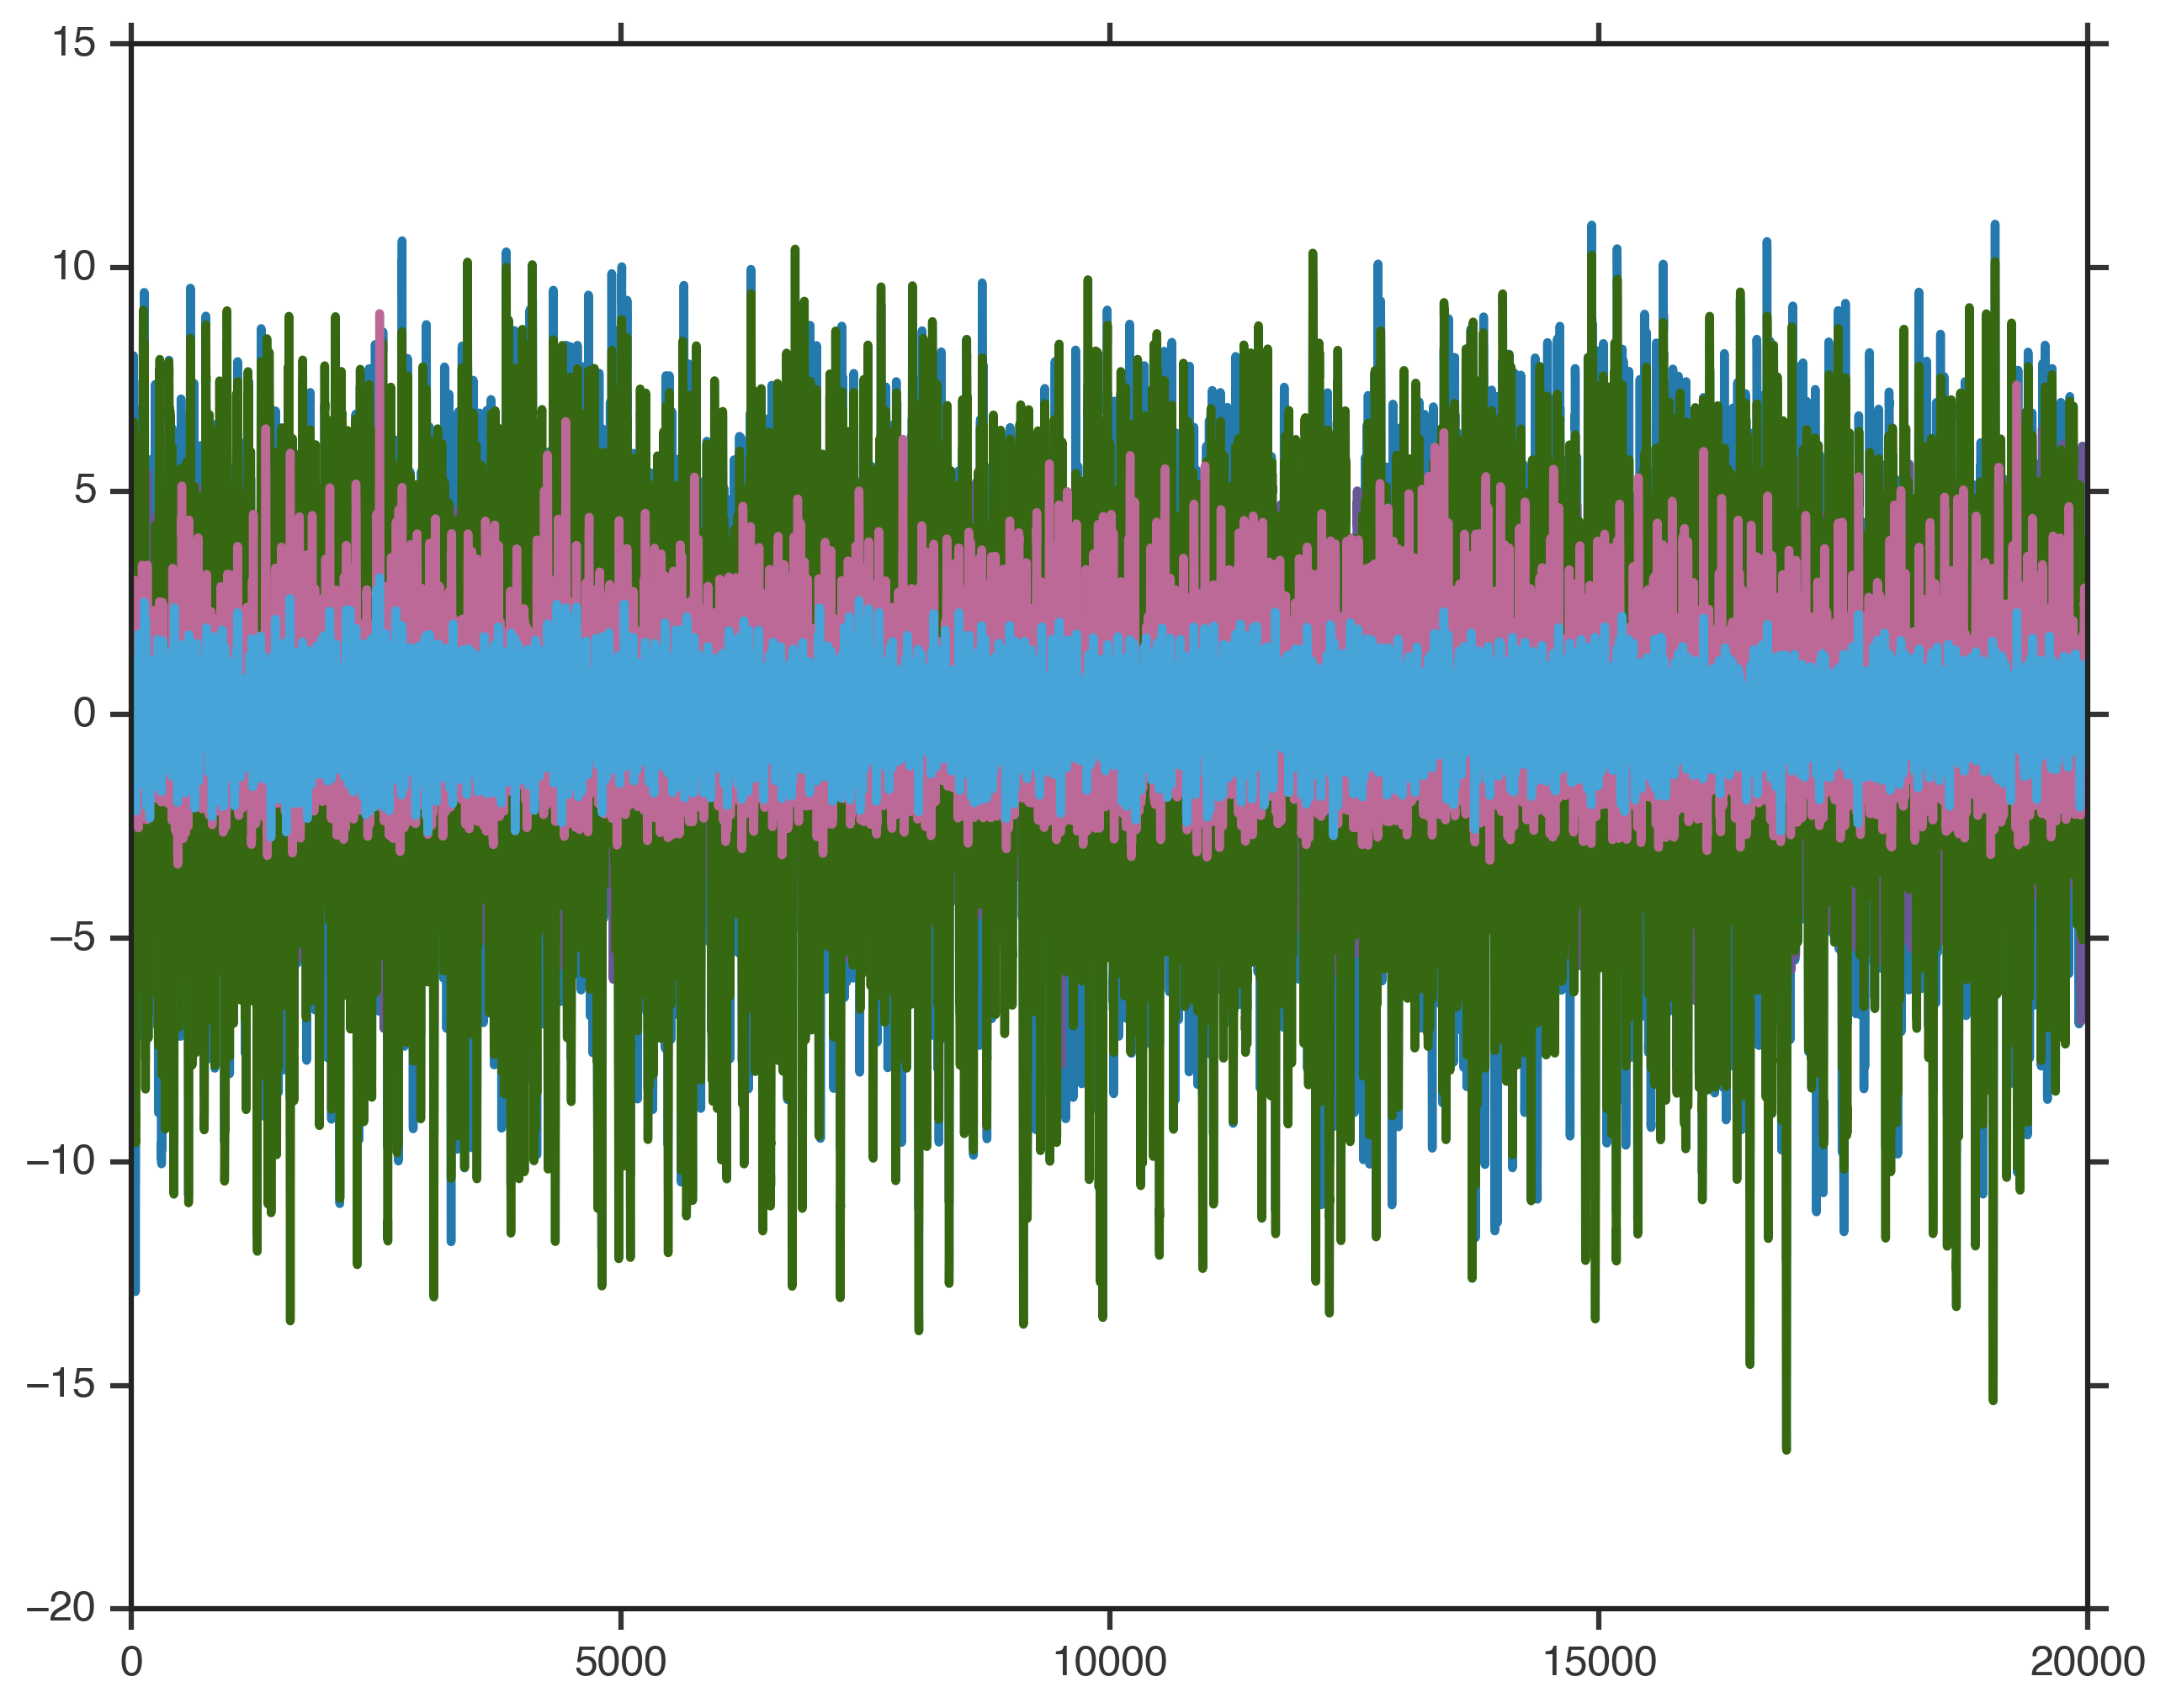

In [45]:
for expt in detrended_membrane_potentials['linesRF_v']:
    plt.plot(detrended_membrane_potentials['linesRF_v'][expt])
# xlim(200,220)

In [46]:
np.stack([detrended_membrane_potentials['linesRF_v'][key] for key in detrended_membrane_potentials['linesRF_v']]).shape

(7, 19988)

## Save h5 file

In [47]:
sorted_expts = sorted([key for key in detrended_membrane_potentials['intraRF_v']])

In [48]:
sorted_expts

['2011_1214_c1',
 '2012_0110_c1',
 '2012_0112_c1',
 '2012_1125_c1',
 '2012_1202_r2_c1',
 '2012_1218_r2_c2',
 '2012_1225_r2_c1']

In [49]:
[len(s) for s in sorted_expts]

[12, 12, 12, 12, 15, 15, 15]

# Different experiments between early 2012 and late 2012

In [51]:
expt = '2011_1214_c1'
early_stimuli = {}
early_stimuli_time = {}

for idh,a_file in enumerate(bipolars):
    a_id = a_file.split('/')[-1]
    if a_id == expt:
        # stimuli
        boxes = np.loadtxt(a_file + '/boxes.txt', skiprows=1)
        lines = np.loadtxt(a_file + '/lines.txt', skiprows=1)
        flashStim = np.loadtxt(a_file + '/flashStim.txt', skiprows=1)
        
        # reshape stimuli
        boxes = boxes.reshape((-1, 38, 38))
        lines = lines.reshape((-1, 100))
        
        # read README to get times
        times = collections.defaultdict(list)
        with open(a_file + '/README.txt', 'r') as f:
            text = f.read()
            readme_lines = text.split('\n')
            for l in readme_lines:
                params = l.split(', ')
                if params[0] in ['flashStim', 'boxes', 'lines']:
                    times[params[0]] = np.linspace(float(params[-2]), float(params[-1]), len(eval(params[0])))
                    scaling_factor = np.mean(np.diff(times[params[0]]))/sampling_rate
                    if scaling_factor > 1:
                        print('%s in %s is going to be upsampled by %f' %(params[0], a_id, scaling_factor))
                        stim_us, time_us = st.upsample_stim(eval(params[0]), int(scaling_factor), times[params[0]])
                    else:
                        print('%s in %s is going to be downsampled by %f' %(params[0], a_id, 1./scaling_factor))
                        stim_us, time_us = st.downsample_stim(eval(params[0]), int(1./scaling_factor), times[params[0]])

                    if params[0] in ['flashStim']:
                        idx = np.argmin(abs(minimum_times['flash_v'] - time_us))
                        early_stimuli_time['flashStim'] = time_us[:idx]
                        early_stimuli['flashStim'] = stim_us[:idx]
                    elif params[0] in ['boxes']:
                        idx = np.argmin(abs(minimum_times['intraRF_v'] - time_us))
                        early_stimuli_time['boxes'] = time_us[:idx]
                        early_stimuli['boxes'] = stim_us[:idx]
                    elif params[0] in ['lines']:
                        idx = np.argmin(abs(minimum_times['linesRF_v'] - time_us))
                        early_stimuli_time['lines'] = time_us[:idx]
                        early_stimuli['lines'] = stim_us[:idx]

boxes in 2011_1214_c1 is going to be upsampled by 3.334796
lines in 2011_1214_c1 is going to be upsampled by 3.334978
flashStim in 2011_1214_c1 is going to be downsampled by 99.999545


In [52]:
stimuli['lines'].shape

(19988, 100)

In [53]:
early_stimuli['lines'].shape

(17991, 100)

In [63]:
early_sorted_expts = [expt for expt in sorted_expts if (float(expt[5:7]) < 4) or (expt[2:4] == '11')]

In [64]:
sorted_expts

['2011_1214_c1',
 '2012_0110_c1',
 '2012_0112_c1',
 '2012_1125_c1',
 '2012_1202_r2_c1',
 '2012_1218_r2_c2',
 '2012_1225_r2_c1']

In [65]:
early_sorted_expts

['2011_1214_c1', '2012_0110_c1', '2012_0112_c1']

In [66]:
late_sorted_expts = [expt for expt in sorted_expts if expt not in early_sorted_expts]

In [71]:
late_sorted_expts

['2012_1125_c1', '2012_1202_r2_c1', '2012_1218_r2_c2', '2012_1225_r2_c1']

In [73]:
[n.encode("ascii", "ignore") for n in late_2012_expts]

[b'2012_1125_c1', b'2012_1202_r2_c1', b'2012_1218_r2_c2', b'2012_1225_r2_c1']

# late experiments

In [74]:
late_2012_expts = late_sorted_expts
with h5py.File('bipolars_late_2012.h5', 'w') as g:
    # expts
    ascii_expts = [n.encode("ascii", "ignore") for n in late_2012_expts]
    g.create_dataset('expts', (len(ascii_expts),1), 'S15', ascii_expts)
    
    # stimuli
    g.create_dataset('lines/stimuli', data=stimuli['lines'])
    g.create_dataset('boxes/stimuli', data=stimuli['boxes'])
    g.create_dataset('flashes/stimuli', data=stimuli['flashStim'])
    
    # time
    g.create_dataset('lines/time', data=stimuli_time['lines'])
    g.create_dataset('boxes/time', data=stimuli_time['boxes'])
    g.create_dataset('flashes/time', data=stimuli_time['flashStim'])
    
    # receptive fields
    for expt in late_2012_expts:
        g.create_dataset('lines/rfs/%s' %expt, data=receptive_fields['linesRF'][expt])
        g.create_dataset('boxes/rfs/%s' %expt, data=receptive_fields['intraRF'][expt])
        g.create_dataset('flashes/rfs/%s' %expt, data=receptive_fields['flash'][expt])
        
    # membrane potentials
    g.create_dataset('lines/membrane_potential',
                    data=np.stack(membrane_potentials['linesRF_v'][key] for key in late_2012_expts))
    g.create_dataset('boxes/membrane_potential',
                data=np.stack(membrane_potentials['intraRF_v'][key] for key in late_2012_expts))
    g.create_dataset('flashes/membrane_potential',
                data=np.stack(membrane_potentials['flash_v'][key] for key in late_2012_expts))
    
    # detrended membrane potentials
    g.create_dataset('lines/detrended_membrane_potential',
                    data=np.stack(detrended_membrane_potentials['linesRF_v'][key] for key in late_2012_expts))
    g.create_dataset('boxes/detrended_membrane_potential',
                data=np.stack(detrended_membrane_potentials['intraRF_v'][key] for key in late_2012_expts))
    g.create_dataset('flashes/detrended_membrane_potential',
                data=np.stack(detrended_membrane_potentials['flash_v'][key] for key in late_2012_expts))

# early experiments

In [68]:
early_2012_expts = early_sorted_expts

In [69]:
sampling_rate = 0.01
early_target_times = {}
for key in minimum_times.keys():
    if key == 'intraRF_v':
        early_target_times[key] = early_stimuli_time['boxes']
    elif key == 'linesRF_v':
        early_target_times[key] = early_stimuli_time['lines']
    elif key == 'flash_v':
        early_target_times[key] = early_stimuli_time['flashStim']
        
smoothing_step = int(2/.001) # 2 second smoothing filter

for idh,h_file in tqdm(enumerate(bipolars)):
    h_id = h_file.split('/')[-1]
    if h_id in early_2012_expts:
        
        # membrane potential
        intraRF_v = np.loadtxt(h_file + '/intraRF_v.txt', skiprows=1)
        linesRF_v = np.loadtxt(h_file + '/linesRF_v.txt', skiprows=1)
        flash_v = np.loadtxt(h_file + '/flash_v.txt', skiprows=1)
        
        # read README to get times
        times = collections.defaultdict(list)
        with open(h_file + '/README.txt', 'r') as f:
            text = f.read()
            lines = text.split('\n')
            for l in lines:
                params = l.split(', ')
                if params[0] in ['flash', 'flash_v', 'intraRF', 'intraRF_v', 'linesRF_v']:
                    times[params[0]] = np.linspace(float(params[1]), float(params[2]), len(eval(params[0])))
        
        # interpolate membrane potentials
        for key in ['flash_v', 'intraRF_v', 'linesRF_v']:
            mem_pot_interp = interp1d(times[key], eval(key), kind='linear', bounds_error=False,
                                     fill_value='extrapolate')
            membrane_potentials[key][h_id] = mem_pot_interp(early_target_times[key])
            
            # detrend
            detrended_mem_pot = detrend(eval(key), type='linear', bp=np.arange(smoothing_step, 
                                                                               len(eval(key))-smoothing_step,
                                                                               smoothing_step))
            
            detrended_interp = interp1d(times[key], detrended_mem_pot, kind='linear', bounds_error=False,
                                       fill_value='extrapolate')
            detrended_membrane_potentials[key][h_id] = detrended_interp(early_target_times[key])


11it [00:11,  1.17s/it]


In [76]:
with h5py.File('bipolars_early_2012.h5', 'w') as g:
    # expts
    ascii_expts = [n.encode("ascii", "ignore") for n in early_2012_expts]
    g.create_dataset('expts', (len(ascii_expts),1), 'S12', ascii_expts)
    
    # stimuli
    g.create_dataset('lines/stimuli', data=early_stimuli['lines'])
    g.create_dataset('boxes/stimuli', data=early_stimuli['boxes'])
    g.create_dataset('flashes/stimuli', data=early_stimuli['flashStim'])
    
    # time
    g.create_dataset('lines/time', data=early_stimuli_time['lines'])
    g.create_dataset('boxes/time', data=early_stimuli_time['boxes'])
    g.create_dataset('flashes/time', data=early_stimuli_time['flashStim'])
    
    # receptive fields
    for expt in early_2012_expts:
        g.create_dataset('lines/rfs/%s' %expt, data=receptive_fields['linesRF'][expt])
        g.create_dataset('boxes/rfs/%s' %expt, data=receptive_fields['intraRF'][expt])
        g.create_dataset('flashes/rfs/%s' %expt, data=receptive_fields['flash'][expt])
        
    # membrane potentials
    g.create_dataset('lines/membrane_potential',
                    data=np.stack(membrane_potentials['linesRF_v'][key] for key in early_2012_expts))
    g.create_dataset('boxes/membrane_potential',
                data=np.stack(membrane_potentials['intraRF_v'][key] for key in early_2012_expts))
    g.create_dataset('flashes/membrane_potential',
                data=np.stack(membrane_potentials['flash_v'][key] for key in early_2012_expts))
    
    # detrended membrane potentials
    g.create_dataset('lines/detrended_membrane_potential',
                    data=np.stack(detrended_membrane_potentials['linesRF_v'][key] for key in early_2012_expts))
    g.create_dataset('boxes/detrended_membrane_potential',
                data=np.stack(detrended_membrane_potentials['intraRF_v'][key] for key in early_2012_expts))
    g.create_dataset('flashes/detrended_membrane_potential',
                data=np.stack(detrended_membrane_potentials['flash_v'][key] for key in early_2012_expts))